##### ---- description --
this code demonstrates how to identify the best model for each PFT, which is then selected for model tuning for regional-scale mapping of fCover

### 1 import required packages

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats
import pandas as pd
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
# tf.random.set_seed(42)


### 2 import training data 
examine the spectral separability of different PFTs

In [2]:
#### load the data from : /mnt/poseidon/remotesensing/arctic/data/training
import os
cwd = '/mnt/poseidon/remotesensing/arctic/data/training/Test_05/'
os.chdir(cwd)
os.getcwd

## make path to save the validation and remaining plots
vers = '05/'
result_path = cwd + 'results/' + vers
if not os.path.exists(result_path):
    os.makedirs(result_path)

#### load the Satellite feature 

In [3]:
## Sentinel-2 features
rad = '30m'  # or '50m'
trg = 'parent' # or 'child'
plot_fea = pd.read_csv(cwd + 'features/'+trg+'/'+trg+'_S2_summer_2019_med_' + rad + '_expanded.csv').drop(columns = ['Unnamed: 0'])
# print(plot_fea.columns)
# print(plot_fea.shape)


### -- add S1 or topo if needed --
# ### Sentnel-1 features
# plot_S1 = pd.read_csv(cwd + 'features/parent/parent_S1_summer_2019_med_' + rad + '.csv')
# plot_S1['Site Code'] = 'id_' + plot_S1['Site Code'].astype(str)
# # plot_S1.shape
# # plot_S1.columns
# # display(plot_S1.head())

# ### Topo features
# plot_topo = pd.read_csv(cwd + 'features/parent/parent_topo_summer_2019_med_' + rad + '.csv')
# plot_topo['Site Code'] = 'id_' + plot_topo['Site Code'].astype(str)
# # plot_S1.shape
# # plot_S1.columns
# # display(plot_S1.head())

# ### -- merge features
# plot_fea = plot_fea.merge(plot_S1[['Site Code','VH_median', 'VV_median']], how='inner', on='Site Code')
# plot_fea = plot_fea.merge(plot_topo[['Site Code','aspect', 'elevation', 'hillshade', 'slope']], how='inner', on='Site Code')
# # print(plot_fea.columns)
# print(plot_fea.shape)

#### load the fractional cover info (response)

In [4]:
### fcover plus the Cook's distance
plot_fcover_cooks = pd.read_csv(cwd + 'results/' + trg+'_2_halfQ1_S2/'+trg+'_fcover_valIDX_' + rad + '.csv').drop(columns = ['Unnamed: 0'])
selected_cols = ['non-vascular total cover (%)', 'forb total cover (%)', 'graminoid total cover (%)',
                 'deciduous shrub total cover (%)', 'evergreen shrub total cover (%)',
                 'litter total cover (%)', 'bare ground top cover (%)', 'water top cover (%)']
new_cols = ['non-vascular', 'forb', 'graminoid', 'deciduous shrub','evergreen shrub', 'litter','bare ground', 'water']
plot_fcover_cooks.rename(columns={col: new_cols[i] for i, col in enumerate(selected_cols)}, inplace=True)
plot_fcover_cooks[new_cols] = plot_fcover_cooks[new_cols]*0.01
# plot_fcover_cooks.columns
# ###-- test whether id matches
# sum(plot_fcover['Site Code'] == plot_fea['Site Code'])


/tmp/ipykernel_193973/4190779421.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


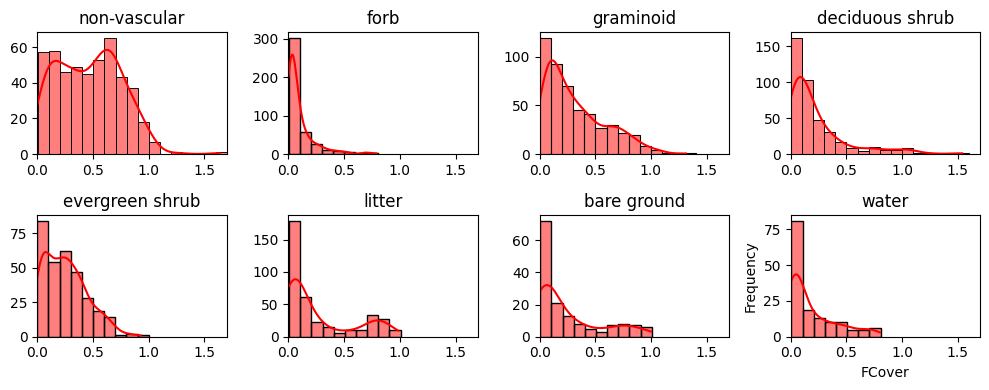

In [7]:
## plot the fCOver histogram for all PFT
df = plot_fcover_cooks[new_cols].copy()
num_columns = df.shape[1]
num_rows = int(np.ceil(num_columns / 4))  # Two columns per row
fig, axes = plt.subplots(2, 4,figsize=(10, 2 * num_rows))

# Flatten the axes array if there is only one row of subplots
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Create histograms with a curve for each column
for i, col in enumerate(df.columns):
    row_idx = i // 4
    col_idx = i % 4
    ax = axes[row_idx, col_idx]

    # Plot histogram
    sns.histplot(df[col][df[col]>0], kde=True, 
                 binwidth=0.1, ax=ax, color='red')  # only shows non-zero fcover

    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([0,1.7])

# Remove any empty subplots if the number of columns is odd
if num_columns % 4!= 0:
    fig.delaxes(axes[-1, -1])

# Adjust layout
plt.xlabel('FCover ')
plt.ylabel('Frequency')
plt.tight_layout()

# Adjust layout
# plt.xlabel('FCover (%)')
plt.xlabel('FCover')
plt.ylabel('Frequency')
plt.tight_layout()
# plt.close()

output_filename = os.path.join(result_path, f'PFT_distribution_all.png')
plt.savefig(output_filename)

### Fractional Cover Regression

In [8]:
### store auxiliary info for quality examination and plot selection
plot_aux = plot_fcover_cooks.copy()[['Site Code','plot_radius_m', 'source', 'year']]
plot_fea = plot_fea.drop(columns = ['Site Code', 'source'])

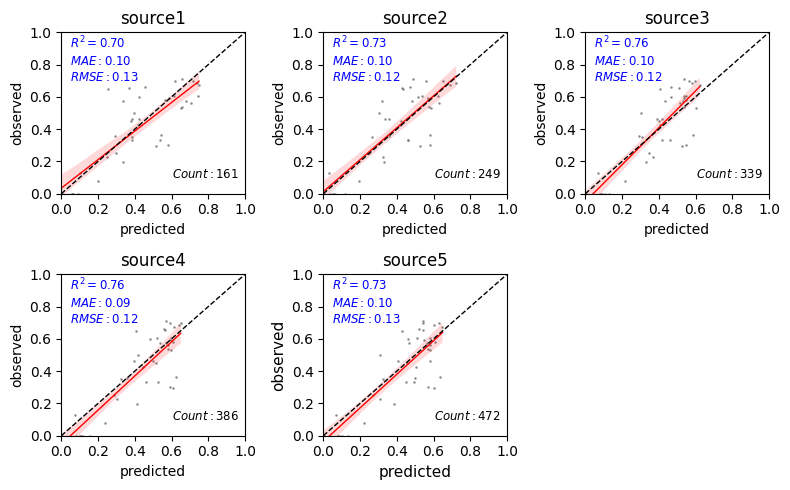

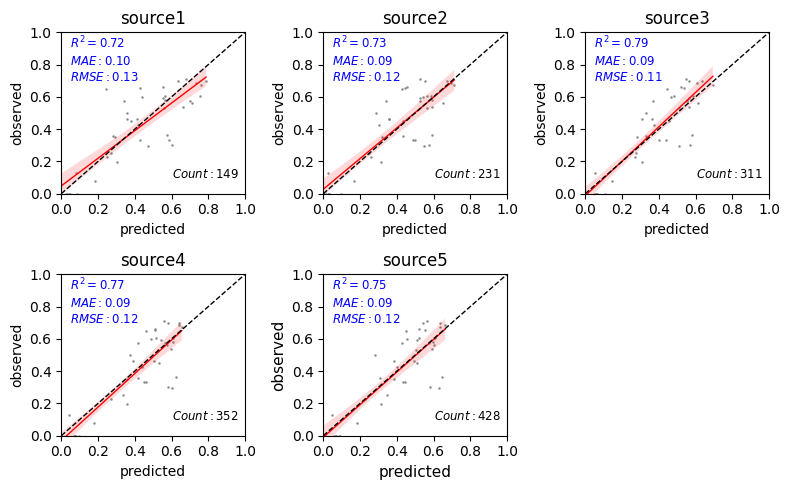

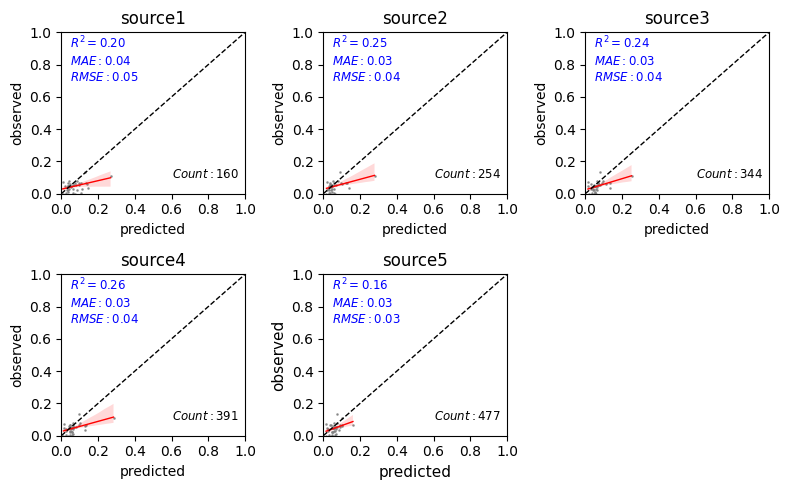

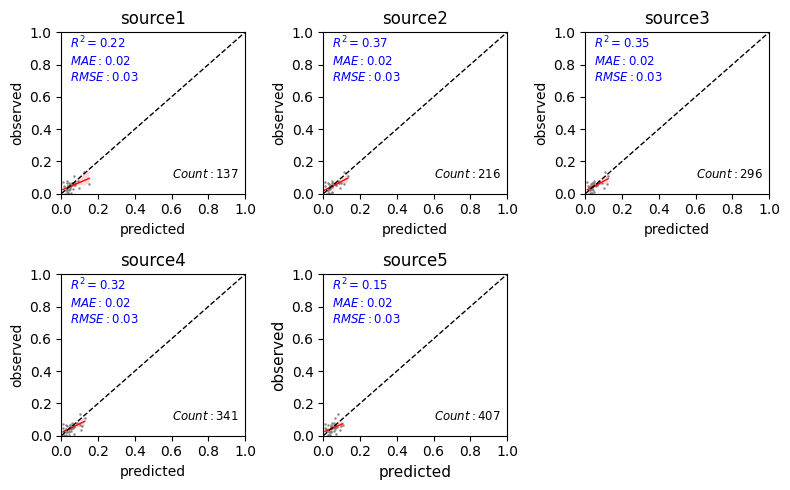

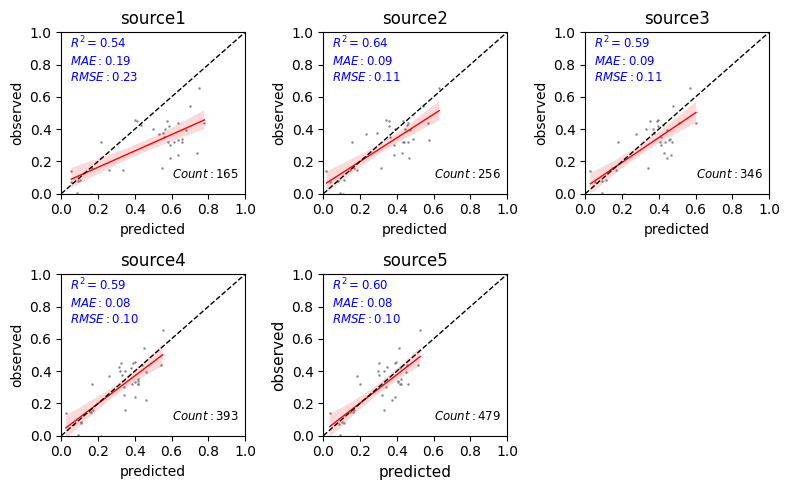

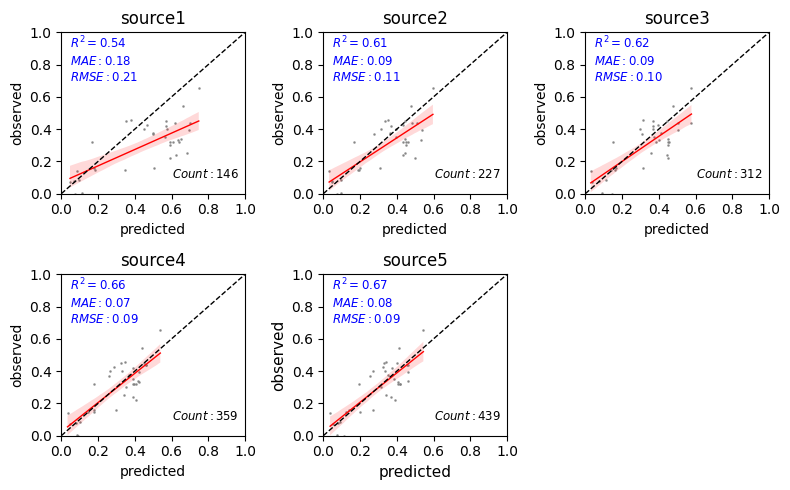

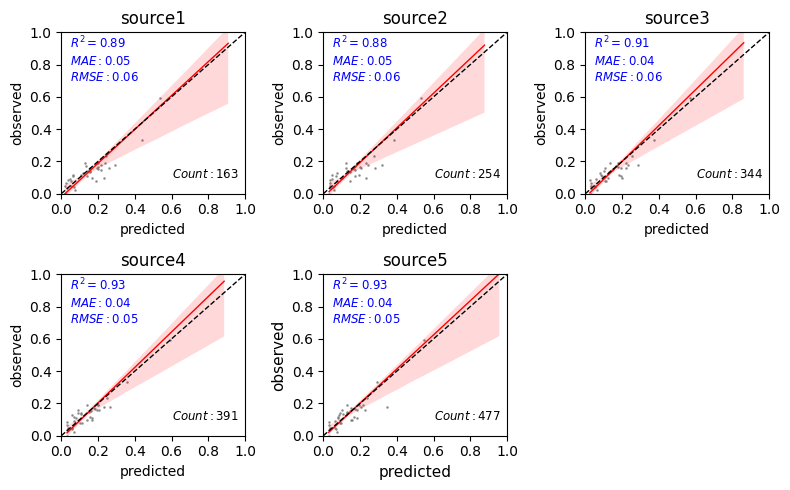

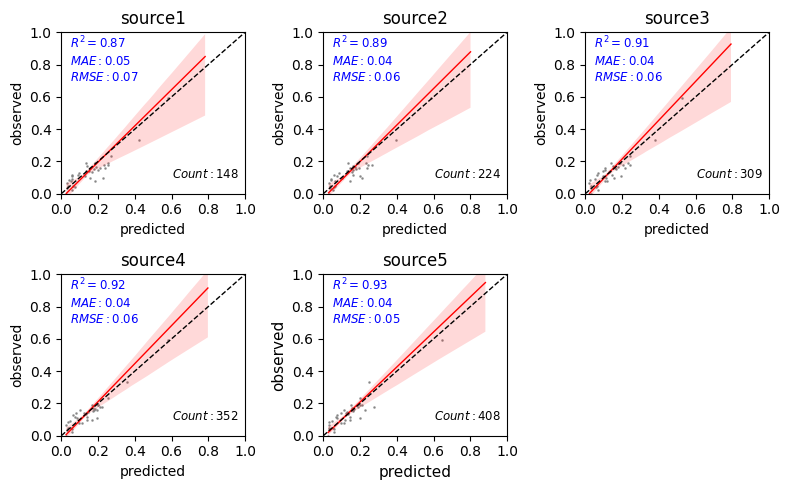

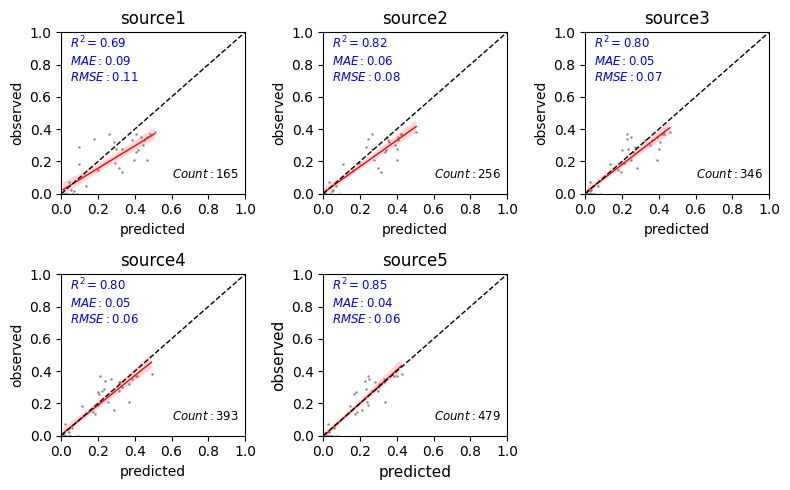

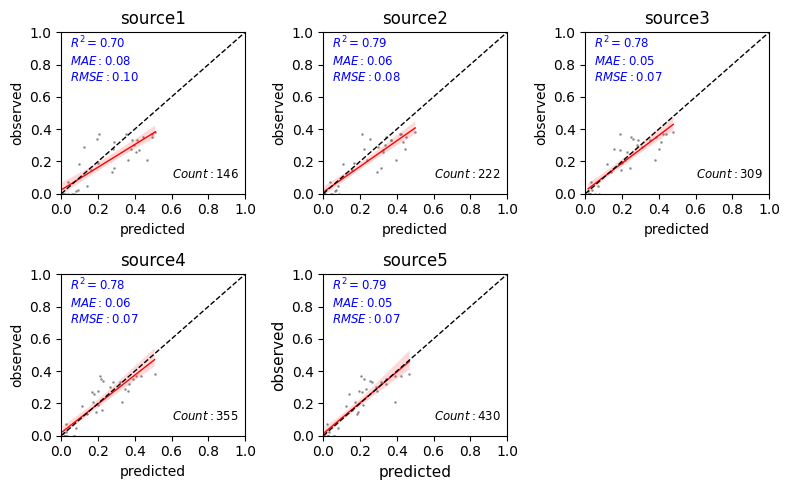

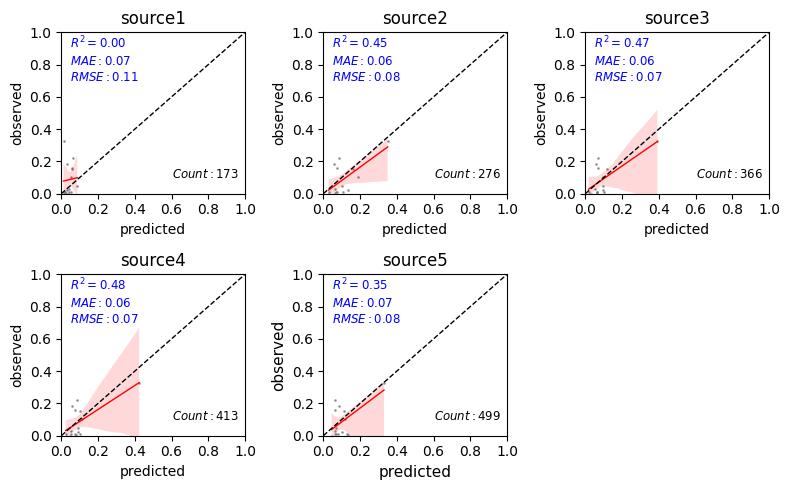

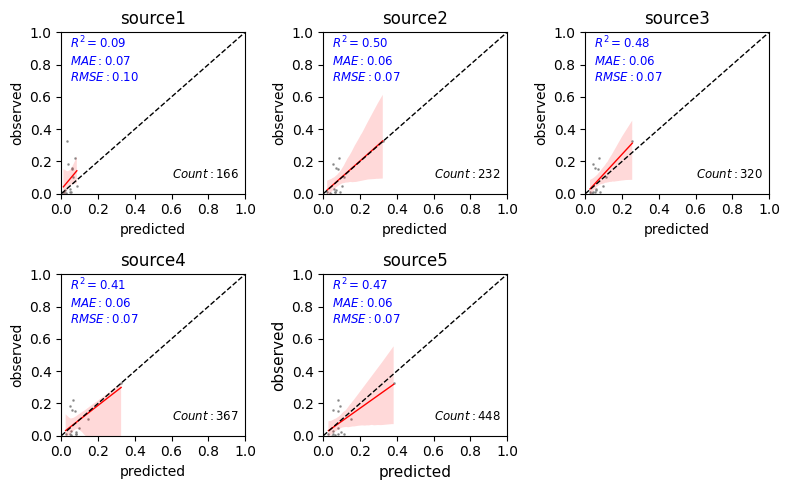

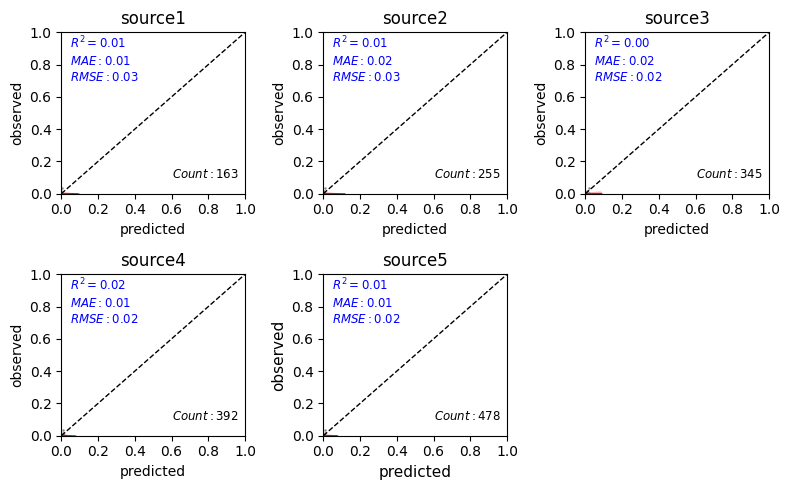

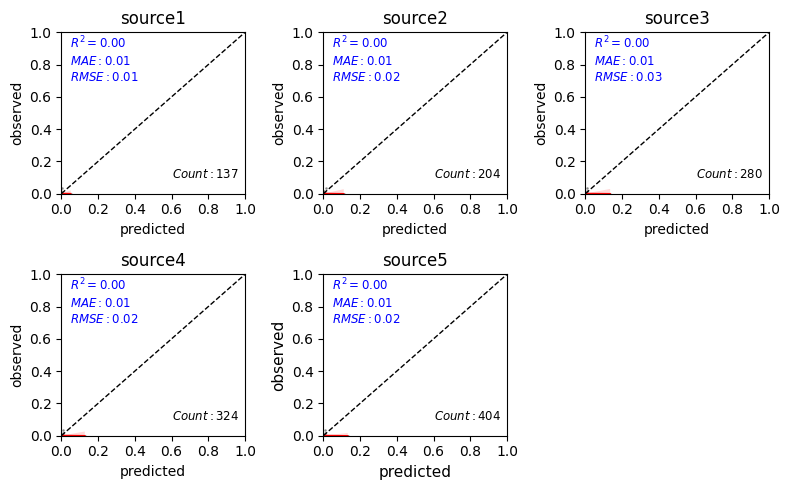

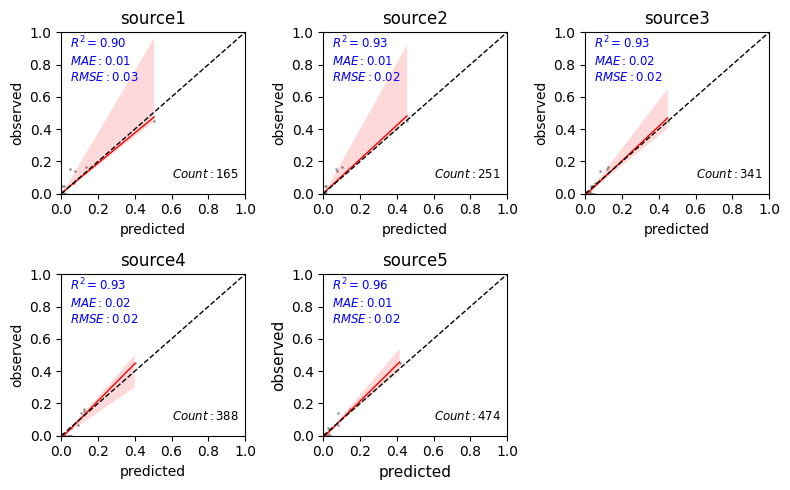

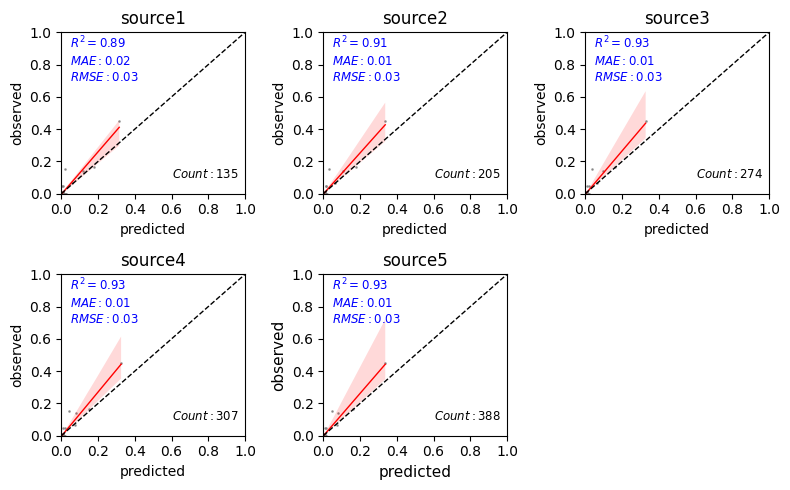

In [9]:
### validation data
#--- use one PFT as example
for col in df.columns:
    PFT = col
    
    #extract all columns with specified PFT
    target = plot_fcover_cooks.copy().filter(like=PFT)
    # target.head()
    
    ## refined_id: < critical distance
    cooks = target.filter(like='cooks')
    thres = (np.quantile(cooks,0.75) - np.quantile(cooks,0.25))*2 + np.quantile(cooks,0.75)
    target['ref_id'] = cooks < thres 
    # target.head()
    
    
    ## divide the data into val and training part (orig)
    flag_val = target['val_' + PFT]
    y_orig, y_test, orig_aux, x_orig, x_test, ref_id = target[PFT][~flag_val], target[PFT][flag_val], plot_aux[~flag_val], plot_fea[~flag_val],plot_fea[flag_val], target['ref_id'][~flag_val]
    
    ## identified the refined samples
    x_ref, y_ref, ref_aux = x_orig[ref_id], y_orig[ref_id],orig_aux[ref_id]
    # print(x_ref.shape)
    # print(ref_aux.shape)
    
    #--- random forest regression and plot the results ---
    RF = RandomForestRegressor(n_estimators=100, max_depth=10, max_features = 10,random_state=42)
    
    fig = plt.figure(figsize=(8,5))
    fig.subplots_adjust(hspace=0.8, wspace=0.3)
    
    src = orig_aux.source.unique()
    for i in range(len(src)):
        # print(src[0:i+1])  
        flag_src = orig_aux['source'].isin(src[0:i+1])
        RF.fit(x_orig[flag_src],y_orig[flag_src])
        yhat_RF = RF.predict(x_test) 
    
        pred = yhat_RF.copy()  # change to another yhat
        test = y_test.copy()
        
        flag = np.logical_and(~np.isnan(pred) , ~np.isnan(test))
        pred = pred[flag]
        test = test[flag]
        data = pd.DataFrame(data = {'predicted': pred, 'observed': test})
            
        ax = fig.add_subplot(2, 3, i+1)
        
        #create scatterplot with regression line
        sns.regplot(data, x= 'predicted', y='observed',ci=95, marker=".",
                    color="grey", 
                    line_kws=dict(color="r",linewidth=1), 
                    scatter_kws = dict(s=3))
        
        # plot 1:1 line
        ax.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
        
        # # Calculate R-squared value
        res = stats.linregress(pred,test)
        r_squared = res.rvalue**2
        mse = mean_squared_error(pred,test)
        rmse = mse ** 0.5
        mae = mean_absolute_error(pred,test)
        
        # text = f'$R^2={r_squared:.2f}$'
        ax.text(0.05, 0.9, f'$R^2={r_squared:.2f}$', fontsize=8.5, color = 'blue')
        ax.text(0.05, 0.8, f'$MAE: {mae:.2f}$', fontsize=8.5, color = 'blue')
        ax.text(0.05, 0.7, f'$RMSE: {rmse:.2f}$', fontsize=8.5, color = 'blue')

        count = y_orig[flag_src].shape[0]
        ax.text(0.6, 0.1, f'$Count: {count:.0f}$', fontsize=8.5, color = 'black')
    
        # ax.set_title('+'.join(src[0:i+1]))
        ax.set_title('source' + str(i+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
        ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        
    plt.xlabel("predicted", fontsize = 11)
    plt.ylabel("observed", fontsize = 11)
    plt.tight_layout()
        
    output_filename = os.path.join(result_path, 'scatterplot_{}_{}_orig.png'.format(PFT, rad))
    plt.savefig(output_filename)
    
    
    fig = plt.figure(figsize=(8,5))
    fig.subplots_adjust(hspace=0.8, wspace=0.3)
    
    src = ref_aux.source.unique()
    for i in range(len(src)):
        # print(src[0:i+1])  
        flag_src = ref_aux['source'].isin(src[0:i+1])
        RF.fit(x_ref[flag_src],y_ref[flag_src])
        yhat_RF = RF.predict(x_test) 
    
        pred = yhat_RF.copy()  # change to another yhat
        test = y_test.copy()
        
        flag = np.logical_and(~np.isnan(pred) , ~np.isnan(test))
        pred = pred[flag]
        test = test[flag]
        data = pd.DataFrame(data = {'predicted': pred, 'observed': test})
            
        ax = fig.add_subplot(2, 3, i+1)
        
        #create scatterplot with regression line
        sns.regplot(data, x= 'predicted', y='observed',ci=95, marker=".",
                    color="grey", 
                    line_kws=dict(color="r",linewidth=1), 
                    scatter_kws = dict(s=3))
        
        # plot 1:1 line
        ax.plot([0,1], [0,1], color='black', linestyle='--', linewidth=1)
        
        # # Calculate R-squared value
        res = stats.linregress(pred,test)
        r_squared = res.rvalue**2
        mse = mean_squared_error(pred,test)
        rmse = mse ** 0.5
        mae = mean_absolute_error(pred,test)
        
        # text = f'$R^2={r_squared:.2f}$'
        ax.text(0.05, 0.9, f'$R^2={r_squared:.2f}$', fontsize=8.5, color = 'blue')
        ax.text(0.05, 0.8, f'$MAE: {mae:.2f}$', fontsize=8.5, color = 'blue')
        ax.text(0.05, 0.7, f'$RMSE: {rmse:.2f}$', fontsize=8.5, color = 'blue')
    
        count = y_ref[flag_src].shape[0]
        ax.text(0.6, 0.1, f'$Count: {count:.0f}$', fontsize=8.5, color = 'black')
        
        # ax.set_title('+'.join(src[0:i+1]))
        ax.set_title('source' + str(i+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
        ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        
    plt.xlabel("predicted", fontsize = 11)
    plt.ylabel("observed", fontsize = 11)
    plt.tight_layout()
        
    output_filename = os.path.join(result_path, 'scatterplot_{}_{}_ref.png'.format(PFT, rad))
    plt.savefig(output_filename)
    # plt.close()
